In [1]:
from io import BytesIO
from datetime import datetime
import tarfile
import json
import os

import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
start_from_datetime = datetime.strptime("27/01/2025 14:00", "%d/%m/%Y %H:%M")

In [3]:
with open('./t-fors_data.tar.gz', 'rb') as f:
    archive = BytesIO(f.read())

with tarfile.open(fileobj=archive, mode='r:gz') as tar:
    dfs = []
    for member in tar.getmembers():
        if member.isfile() and member.name.endswith('.json'):
            file_name = os.path.basename(member.name)
            date_time = file_name.split('_')[2].split('.')[0]
            date_time = datetime.strptime(date_time, "%Y%m%dT%H%M%S")
            
            if date_time >= start_from_datetime:
                file_obj = tar.extractfile(member)
                if file_obj:
                    data = json.load(file_obj).get("data", {})
                    df = pd.DataFrame([data])
                    df["source_file"] = file_name
                    dfs.append(df)
                    
df = pd.concat(dfs, ignore_index=True)

C:\Users\vince\AppData\Local\Temp\ipykernel_17856\3593352745.py:20: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [4]:
df['datetime_ref'] = pd.to_datetime(df['datetime_ref'])
df['datetime_run'] = pd.to_datetime(df['datetime_run'])

df = df.astype(
    {
        'prediction_score': float,
        'prediction_calib': float,
        'prediction_hprec': int,
        'prediction_balan': int,
        'prediction_hsens': int,
        'input_availability_score': float,
        'input_availability_alert': bool,
        'ie_fix': float,
        'ie_variation': int,
        'ie_mav_3h': float,
        'ie_mav_12h': float,
        'iu_fix': float,
        'iu_variation': int,
        'iu_mav_3h': float,
        'iu_mav_12h': float,
        'hf': float,
        'hf_mav_2h': float,
        'f_107_adj': float,
        'hp_30': float,
        'dst': float,
        'solar_zenith_angle': float,
        'newell': float,
        'bz': float,
        'speed': float,
        'rho': float,
        'spectral_contribution_at': float,
        'spectral_contribution_ff': float,
        'spectral_contribution_jr': float,
        'spectral_contribution_pq': float,
        'spectral_contribution_ro': float,
        'spectral_contribution_vt': float,
        'azimuth_at': float,
        'azimuth_ff': float,
        'azimuth_jr': float,
        'azimuth_pq': float,
        'azimuth_ro': float,
        'azimuth_vt': float,
        'velocity_at': float,
        'velocity_ff': float,
        'velocity_jr': float,
        'velocity_pq': float,
        'velocity_ro': float,
        'velocity_vt': float,
        'source_file': object,
    }
).set_index('datetime_ref').sort_index()

## Quanti *NaN* per ogni colonna?

In [5]:
df_numeric = df.select_dtypes(include=['float64', 'int64'])

nas = np.round(
    100 * df_numeric.isna().sum().div(df_numeric.shape[0]),
    1,
).sort_values(ascending=False)

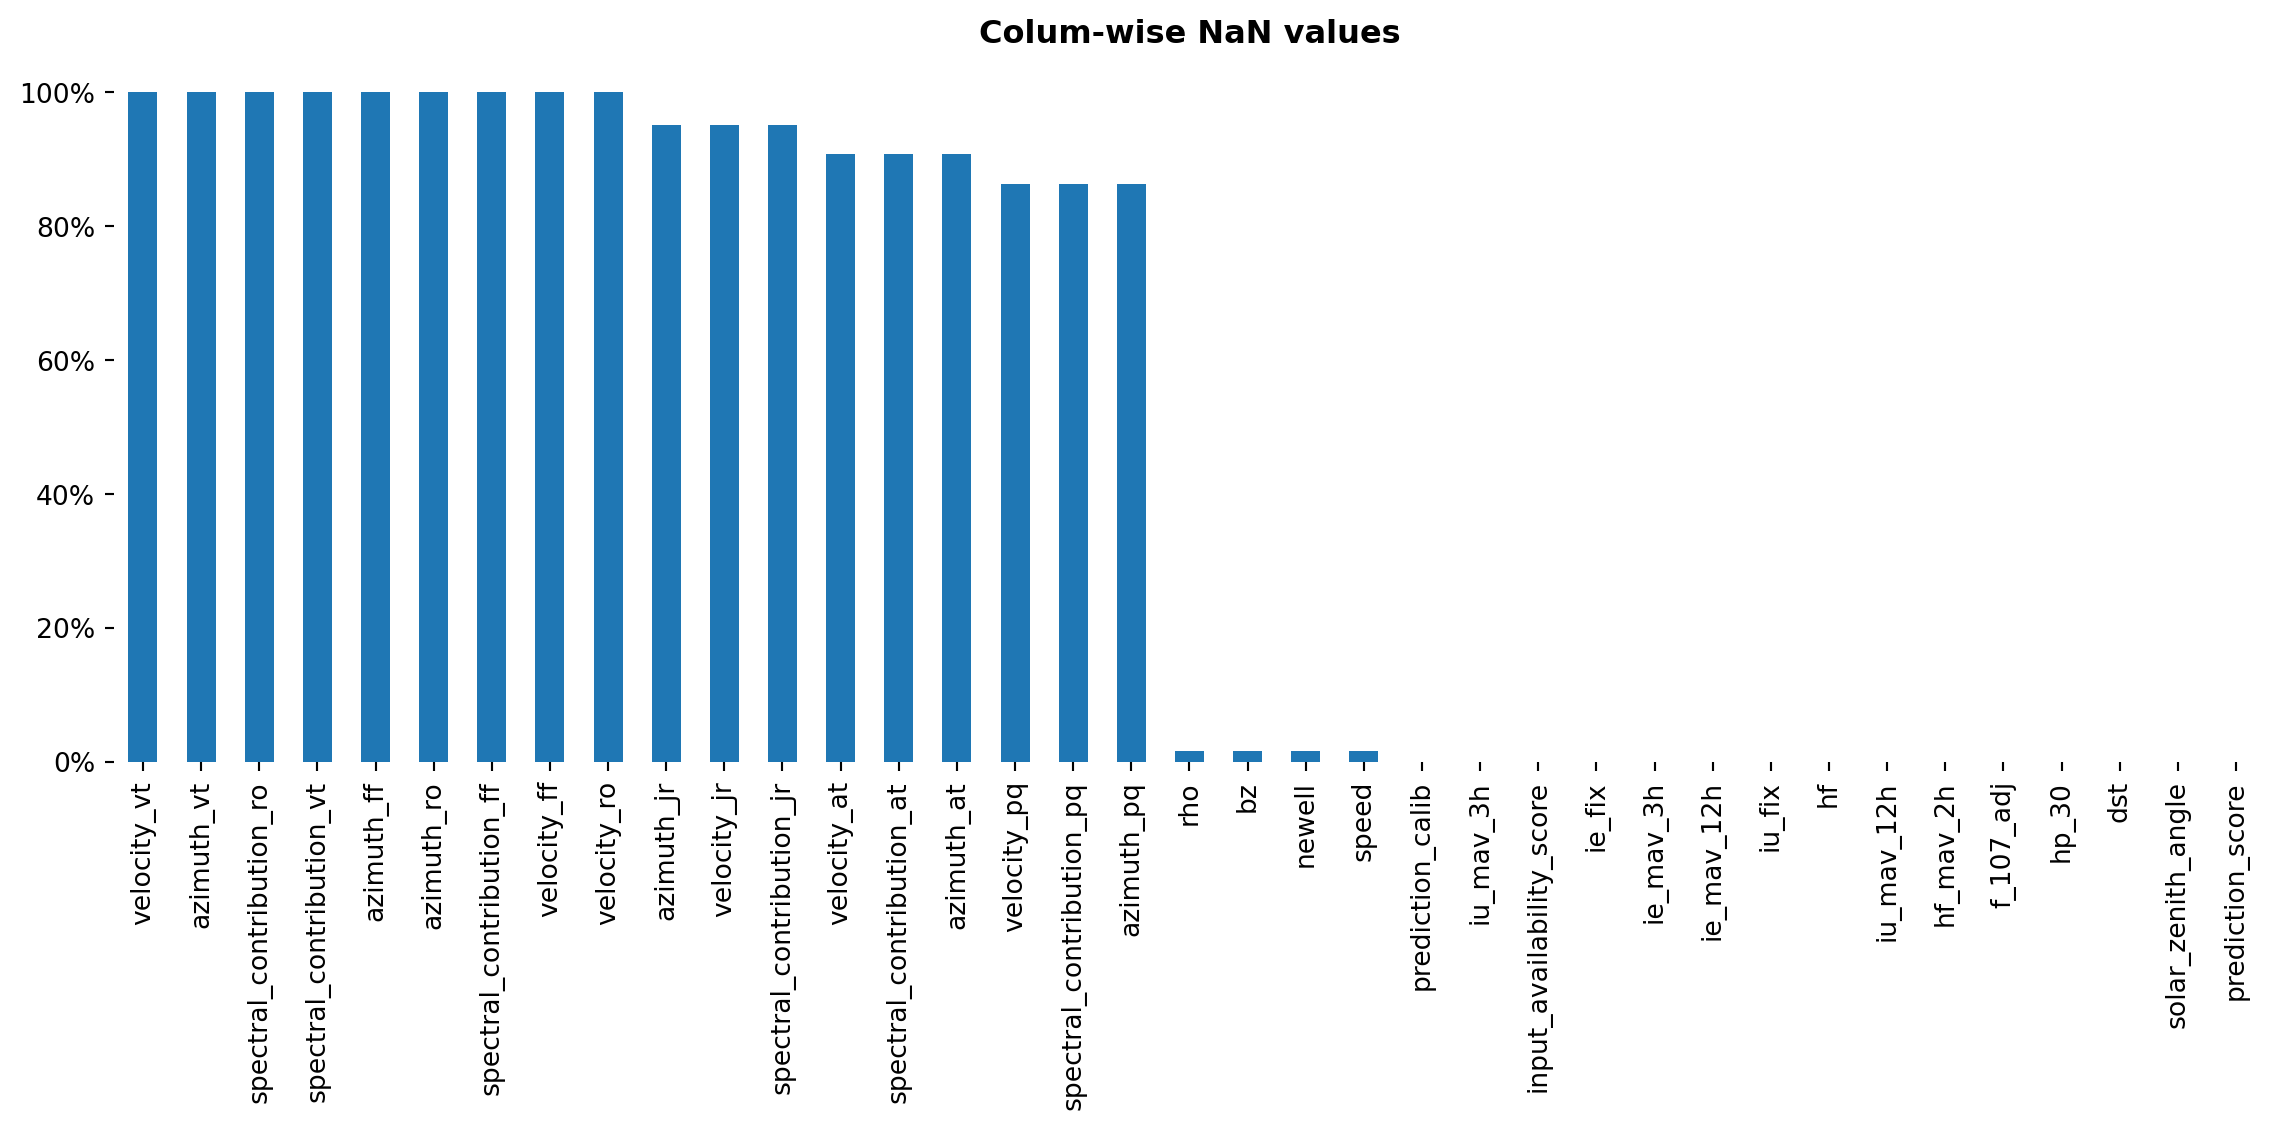

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
nas.plot(kind='bar', ax=ax)

ax.set_title('Colum-wise NaN values', fontdict={'fontweight': 'bold'})

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
[ax.spines[s].set_visible(False) for s in ax.spines]

plt.tight_layout()
plt.show()

## Quanto impiega l'intero processo a girare?

In [7]:
df['elapsed_time'] = (
    df['datetime_run'] - (pd.to_datetime(df.index) + pd.Timedelta(minutes=15))
).dt.total_seconds()

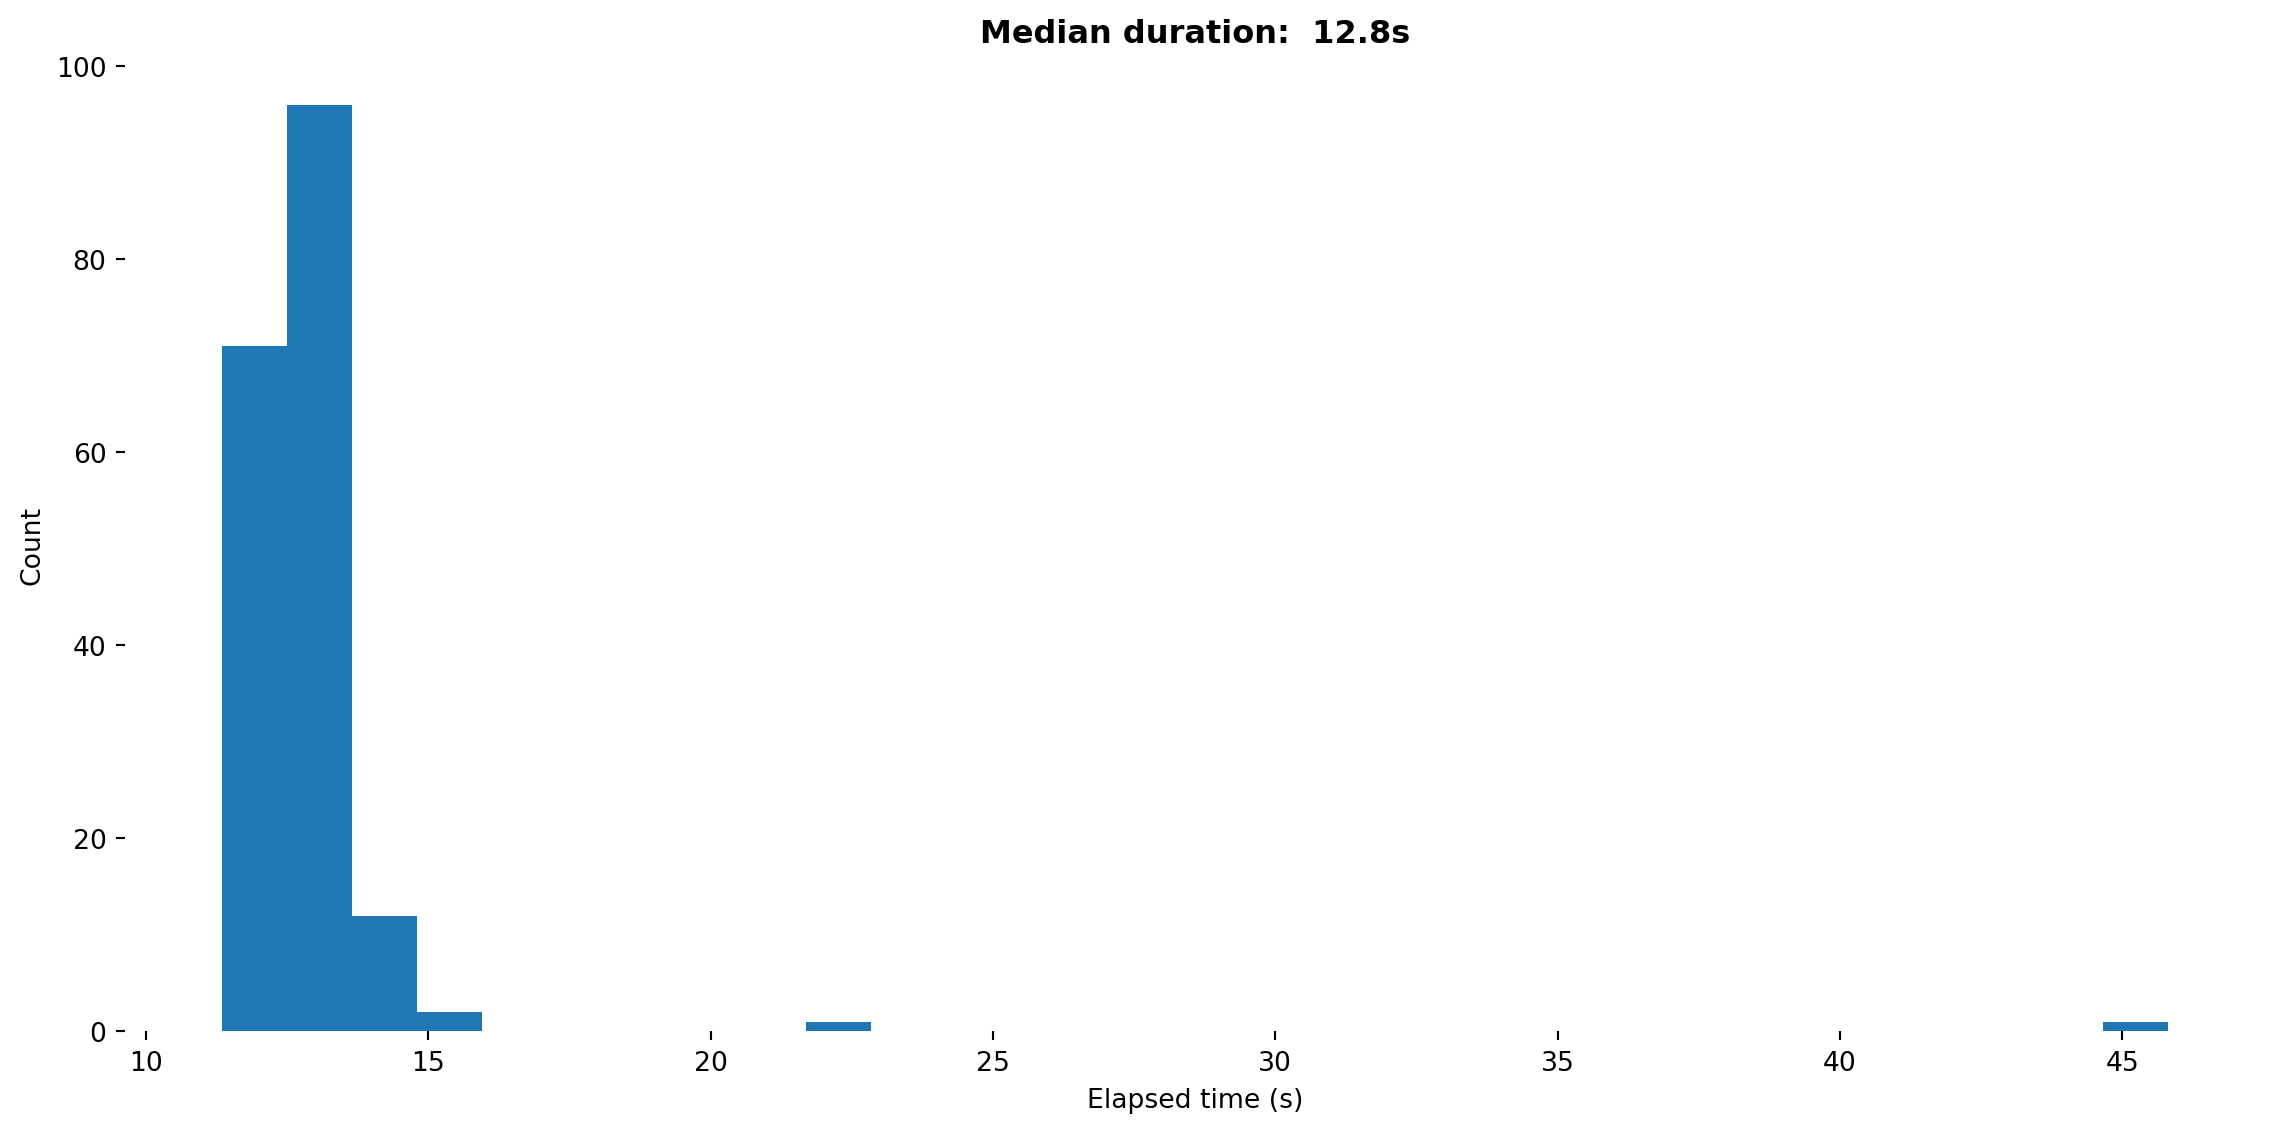

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(df['elapsed_time'], bins=30)

ax.set_title(f"Median duration: {df['elapsed_time'].median(): .1f}s", fontdict={'fontweight': 'bold'})
ax.set_xlabel('Elapsed time (s)')
ax.set_ylabel('Count')
[ax.spines[s].set_visible(False) for s in ax.spines]

plt.tight_layout()
plt.show()

## Output del modello

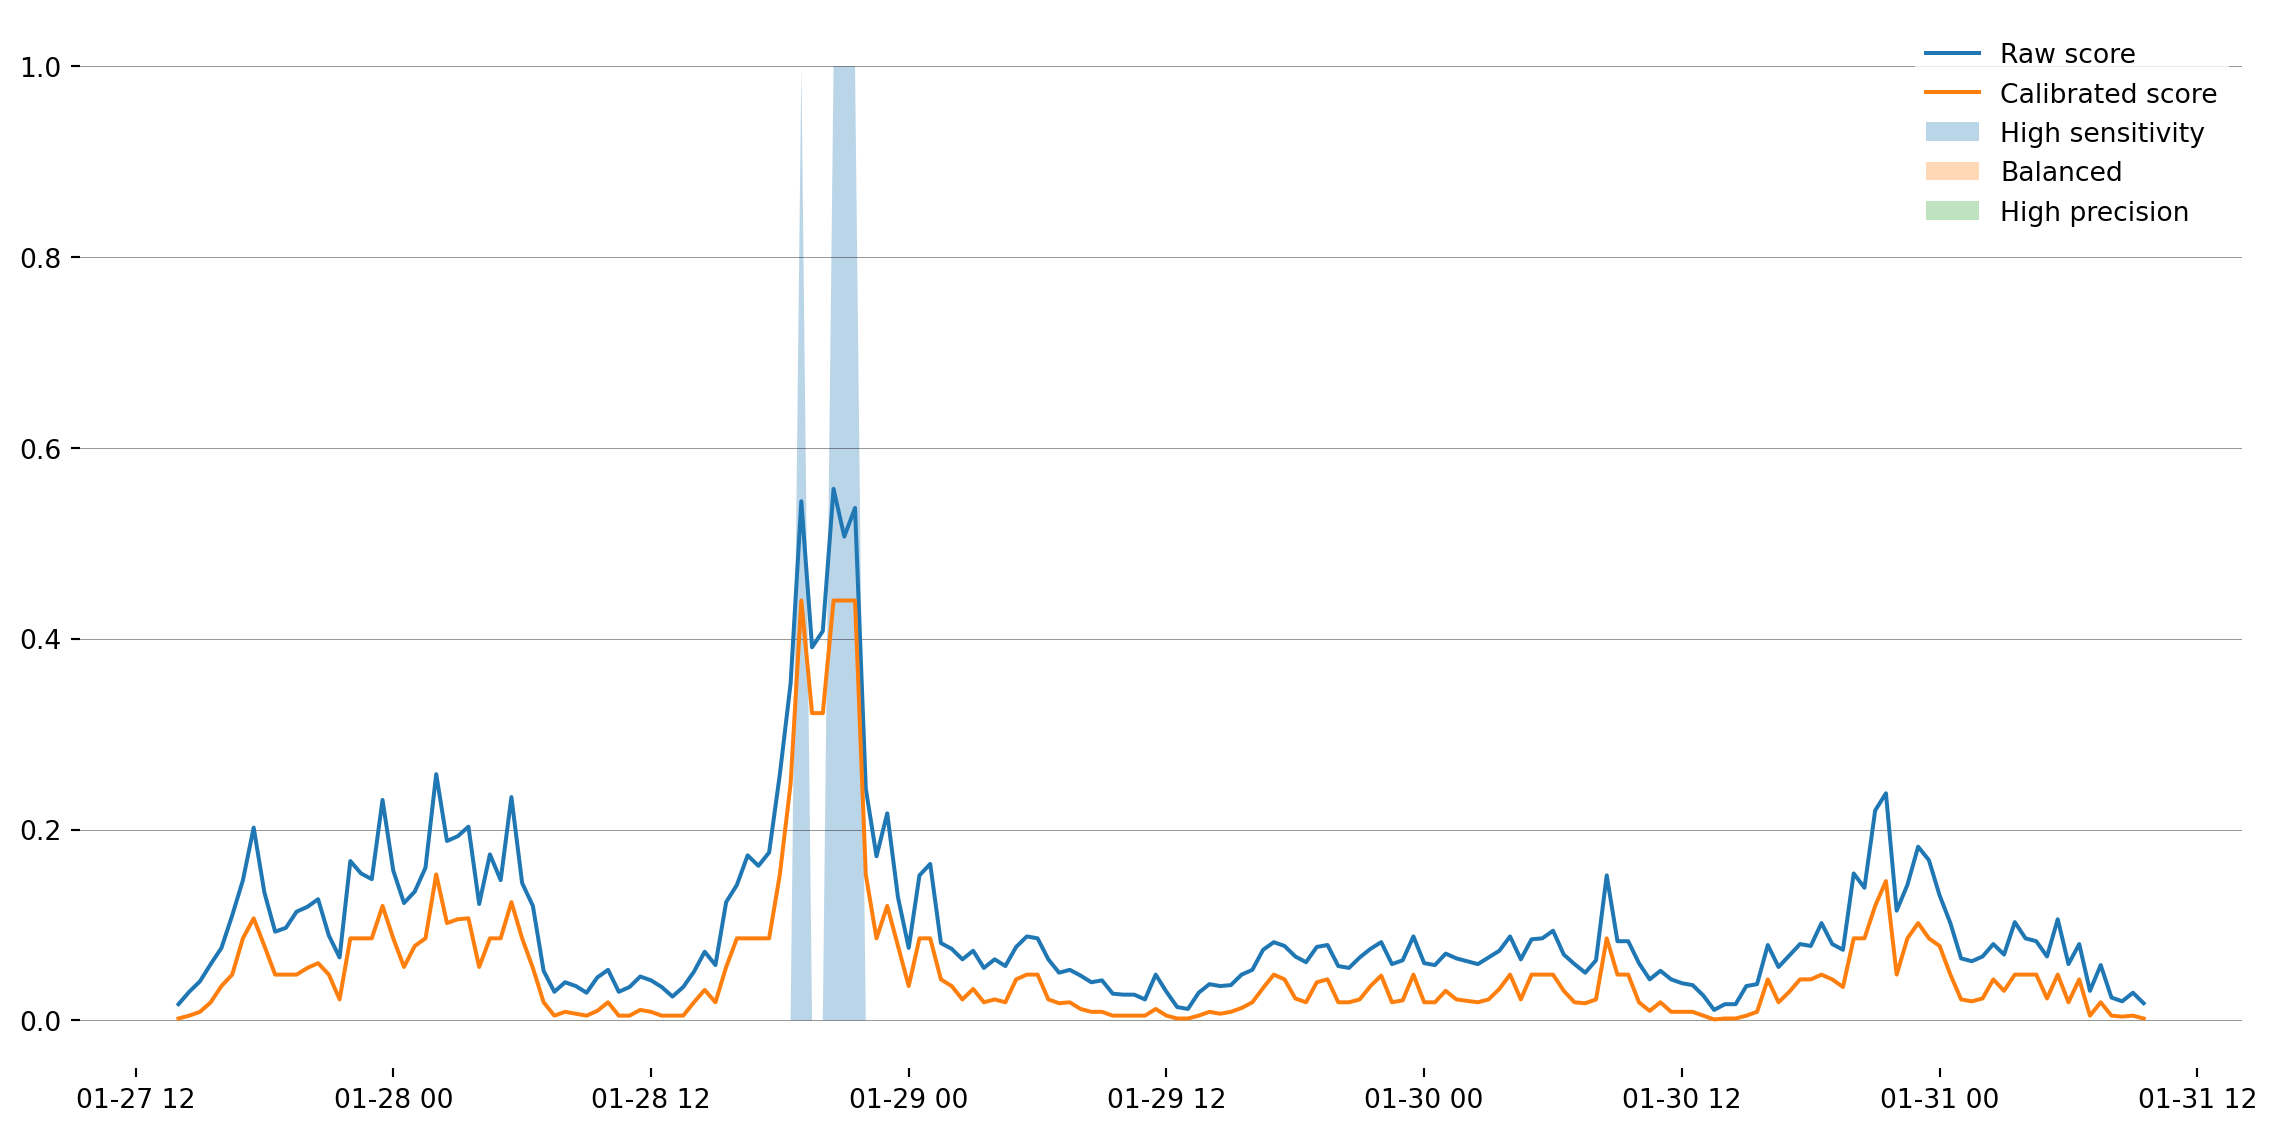

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df['prediction_score'], label='Raw score')
ax.plot(df['prediction_calib'], label='Calibrated score')
ax.fill_between(df.index, df['prediction_hsens'], label='High sensitivity', alpha=0.3)
ax.fill_between(df.index, df['prediction_balan'], label='Balanced', alpha=0.3)
ax.fill_between(df.index, df['prediction_hprec'], label='High precision', alpha=0.3)

ax.legend(frameon=True, facecolor='white', edgecolor='none')
ax.yaxis.grid(True, color='k', linestyle='-', linewidth=0.3, alpha=0.5)
[ax.spines[s].set_visible(False) for s in ax.spines]

plt.tight_layout()
plt.show()
